[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


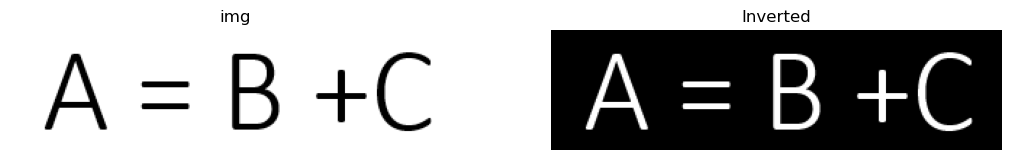

In [12]:
from commonfunctions import *
from skimage.color import rgba2rgb

img  = io.imread('test_images/1.png')
img = rgba2rgb(img)
img = rgb2gray(img)

print(img)

img_inv = 1- img
show_images([img,img_inv],['img','Inverted'])

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
img = cv2.imread('test_images/1.png')

# convert to grayscale
gray =255- cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# smooth the image to avoid noises
# gray = cv2.medianBlur(gray,5)
# Apply adaptive threshold
# thresh = cv2.adaptiveThreshold(gray, 255, 1, 1, 11, 2)
# thresh_color = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

# # apply some dilation and erosion to join the gaps
# kernel = np.ones((5,5), np.uint8)
# thresh = cv2.dilate(thresh, kernel ,iterations = 2)
# thresh = cv2.erode(thresh, kernel, iterations = 2)

print(gray)


22.905977608181924


In [27]:
# Find the contours
contours,hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# For each contour, find the bounding rectangle and draw it
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if h > 10:    
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

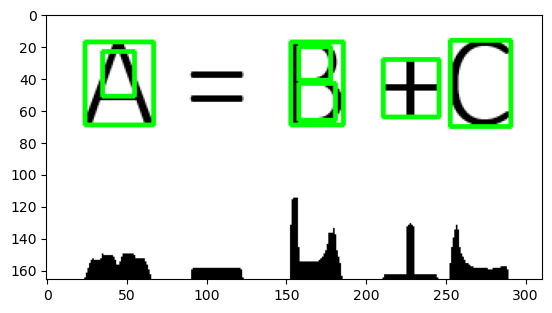

In [28]:
# Width and heigth the image
height, width = gray.shape
# Sum the value lines 
vertical_px = np.sum(gray, axis=0)
# Normalize
normalize = vertical_px/255
# create a black image with zeros 
blankImage = np.zeros_like(gray)
# Make the vertical projection histogram
for idx, value in enumerate(normalize):
    cv2.line(blankImage, (idx, 0), (idx, height-int(value)), (255,255,255), 1)
# Concatenate the image
img_concate = cv2.vconcat(
    [img,  cv2.cvtColor(blankImage, cv2.COLOR_BGR2RGB)])
plt.imshow(img_concate)
plt.show()

(array([[[  0,   0]],

       [[  0,   7]],

       [[  1,   8]],

       [[  0,   9]],

       [[  0,  28]],

       [[399,  28]],

       [[399,   0]]], dtype=int32), array([[[ 5, 11]],

       [[ 6, 12]],

       [[ 7, 12]],

       [[10, 15]],

       [[10, 17]],

       [[ 7, 20]],

       [[ 3, 20]],

       [[ 1, 18]],

       [[ 2, 17]],

       [[ 3, 17]],

       [[ 4, 18]],

       [[ 6, 18]],

       [[ 7, 17]],

       [[ 7, 15]],

       [[ 6, 14]],

       [[ 4, 14]],

       [[ 3, 13]]], dtype=int32), array([[[ 1,  8]],

       [[ 2,  7]],

       [[ 8,  7]],

       [[ 9,  8]],

       [[ 9,  9]],

       [[ 7, 11]],

       [[ 6, 10]],

       [[ 6,  9]],

       [[ 4,  9]],

       [[ 4, 10]],

       [[ 3, 11]],

       [[ 1,  9]]], dtype=int32), array([[[ 5, 11]],

       [[ 6, 10]],

       [[ 7, 11]],

       [[ 6, 12]]], dtype=int32), array([[[13,  7]],

       [[17,  7]],

       [[19,  9]],

       [[19, 12]],

       [[18, 13]],

       [[18, 14]],

       [[

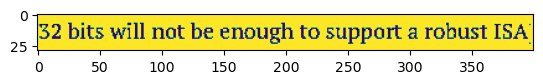

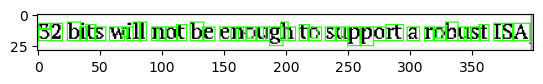

In [10]:
import cv2
from imutils import contours
import matplotlib.pyplot as plt

image = cv2.imread('./test_images/BaKep.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

cnts = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts, _ = contours.sort_contours(cnts, method="left-to-right")

print(cnts)
ROI_number = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > 10:
        x,y,w,h = cv2.boundingRect(c)
        ROI = 255 - image[y:y+h, x:x+w]
        cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 1)
        ROI_number += 1
# plt.imshow('thresh', thresh)
plt.imshow(thresh)
plt.show()
plt.imshow(image)
# plt.imshow('image', image)
# cv2.waitKey()